<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/EfficientNetb4_ExtraConvLayer_DropoutTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=7ae2d278aee81e588ed8bf003af818725a8c5d6f07826a43069afcf138705b54
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from torch.cuda.amp import autocast, GradScaler

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)

100%|██████████| 345M/345M [00:10<00:00, 33.0MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 751kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 19.9MB/s]


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
class CustomEfficientNet(nn.Module):
    def __init__(self, dropout_extra_conv=0.3, dropout_classifier=0.3):
        super(CustomEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')


        self.extra_conv = nn.Sequential(
            nn.Conv2d(1792, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.Conv2d(2048, 2048, kernel_size=3, padding=1),
            nn.BatchNorm2d(2048),
            nn.ReLU(),
            nn.Dropout(dropout_extra_conv)
        )


        num_ftrs = 2048
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_classifier),
            nn.Linear(512, 102)
        )

    def forward(self, x):
        x = self.base_model.extract_features(x)
        x = self.extra_conv(x)
        x = self.classifier(x)
        return x


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
scaler = GradScaler()

<ipython-input-8-9f6a838c5572>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [ ]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()


        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [ ]:

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), correct / total

In [ ]:
def test_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
dropout_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
num_epochs = 100
patience = 5
best_val_acc = 0.0
best_model_config = None
criterion = nn.CrossEntropyLoss()


for dropout_rate in dropout_values:
    print(f"Tuning dropout: extra_conv={dropout_rate}, classifier={dropout_rate}")


    model = CustomEfficientNet(dropout_extra_conv=dropout_rate, dropout_classifier=dropout_rate).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


    counter = 0
    best_val_acc_current = 0.0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


        if val_acc > best_val_acc_current:
            best_val_acc_current = val_acc
            counter = 0
        else:
            counter += 1


        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
            break


    if best_val_acc_current > best_val_acc:
        best_val_acc = best_val_acc_current
        best_model_config = dropout_rate


print(f"Best Dropout Configuration: extra_conv={best_model_config}, classifier={best_model_config}")
print(f"Best Validation Accuracy during tuning: {best_val_acc:.4f}")


best_dropout = best_model_config





Tuning dropout: extra_conv=0, classifier=0


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 183MB/s]


Loaded pretrained weights for efficientnet-b4


<ipython-input-9-de5e9a8c4504>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Train Loss: 4.4269, Train Accuracy: 0.0559, Validation Loss: 4.6410, Validation Accuracy: 0.0490
Epoch [2/100], Train Loss: 3.2409, Train Accuracy: 0.1892, Validation Loss: 3.4498, Validation Accuracy: 0.2196
Epoch [3/100], Train Loss: 2.2548, Train Accuracy: 0.3882, Validation Loss: 3.0555, Validation Accuracy: 0.3069
Epoch [4/100], Train Loss: 1.5446, Train Accuracy: 0.5363, Validation Loss: 2.4997, Validation Accuracy: 0.4549
Epoch [5/100], Train Loss: 1.1555, Train Accuracy: 0.6578, Validation Loss: 2.4834, Validation Accuracy: 0.4490
Epoch [6/100], Train Loss: 0.9422, Train Accuracy: 0.7304, Validation Loss: 2.3720, Validation Accuracy: 0.5167
Epoch [7/100], Train Loss: 0.7528, Train Accuracy: 0.7784, Validation Loss: 1.5213, Validation Accuracy: 0.6490
Epoch [8/100], Train Loss: 0.5654, Train Accuracy: 0.8294, Validation Loss: 1.6994, Validation Accuracy: 0.6284
Epoch [9/100], Train Loss: 0.4331, Train Accuracy: 0.8647, Validation Loss: 1.6652, Validation Accuracy:

In [ ]:
model = CustomEfficientNet(dropout_extra_conv=best_dropout, dropout_classifier=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
best_val_acc=0.0

counter = 0
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)


    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Retrain Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'Best_EfficientNetb4_ExtraConv_DropoutTuned.pth')
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1} during retraining. No improvement in validation accuracy for {patience} consecutive epochs.")
        break


final_results = {
    "train_loss": train_loss_history,
    "train_acc": train_acc_history,
    "val_loss": val_loss_history,
    "val_acc": val_acc_history
}

Loaded pretrained weights for efficientnet-b4


<ipython-input-9-de5e9a8c4504>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Retrain Epoch [1/100], Train Loss: 4.4851, Train Accuracy: 0.0441, Validation Loss: 3.9043, Validation Accuracy: 0.0902
Retrain Epoch [2/100], Train Loss: 3.2870, Train Accuracy: 0.1814, Validation Loss: 3.4124, Validation Accuracy: 0.2078
Retrain Epoch [3/100], Train Loss: 2.5111, Train Accuracy: 0.2951, Validation Loss: 3.0681, Validation Accuracy: 0.3127
Retrain Epoch [4/100], Train Loss: 1.9015, Train Accuracy: 0.4588, Validation Loss: 3.1298, Validation Accuracy: 0.3069
Retrain Epoch [5/100], Train Loss: 1.4811, Train Accuracy: 0.5686, Validation Loss: 1.6785, Validation Accuracy: 0.5539
Retrain Epoch [6/100], Train Loss: 1.1434, Train Accuracy: 0.6402, Validation Loss: 1.6112, Validation Accuracy: 0.5853
Retrain Epoch [7/100], Train Loss: 0.9075, Train Accuracy: 0.7314, Validation Loss: 2.1415, Validation Accuracy: 0.5431
Retrain Epoch [8/100], Train Loss: 0.7436, Train Accuracy: 0.7824, Validation Loss: 1.9487, Validation Accuracy: 0.6108
Retrain Epoch [9/100], Train Loss: 0.584

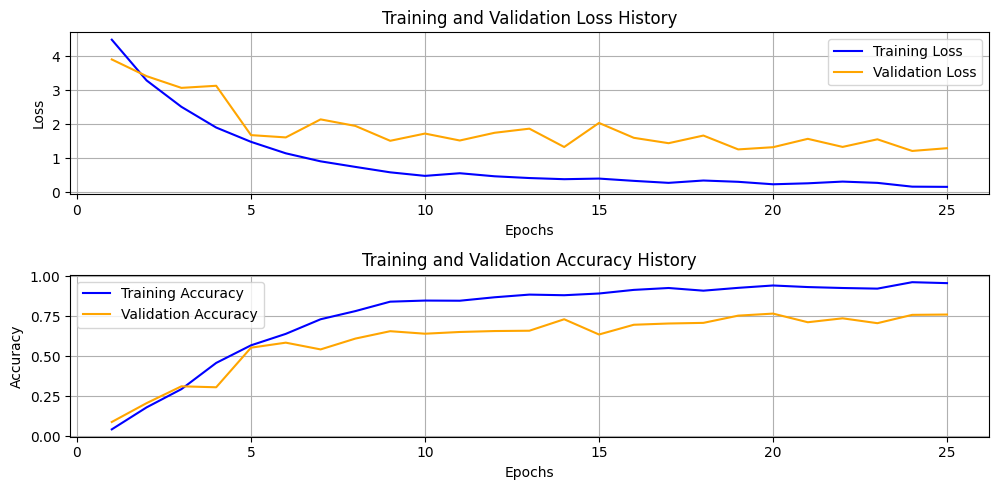

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
model = CustomEfficientNet(dropout_extra_conv=best_dropout, dropout_classifier=best_dropout)
model.to(device)
model.load_state_dict(torch.load('Best_EfficientNetb4_ExtraConv_DropoutTuned.pth'))
test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

Loaded pretrained weights for efficientnet-b4


<ipython-input-19-fe082bf58fae>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_EfficientNetb4_ExtraConv_DropoutTuned.pth'))


Test Accuracy: 0.7209
